In [12]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import gym
import random
import numpy as np   
import matplotlib.pyplot as plt
import collections

# Import Tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam

#import early stopping
from tensorflow.keras.callbacks import EarlyStopping

from IPython.display import HTML

from tqdm import tqdm

tqdm.pandas()

# disable eager execution (optimization)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# ###### Tensorflow-GPU ########

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Double DQN

In [14]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance * 1000
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 1000:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10
            
        # Penalize for each step taken to encourage efficiency
        reward -= 2
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self, framerate=60, delay=0):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)
        
        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
        pygame.time.delay(delay)
        pygame.display.flip()
        self.clock.tick(framerate)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

In [15]:
class DQAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())


    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
      model = Sequential()
      model.add(Dense(32, input_shape=self.input_shape, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(32, activation='relu'))
      model.add(Dense(self.output_shape, activation='linear'))
      model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate), metrics=['MeanSquaredError'])
      return model

    def policy_network_fit(self, batch, batch_size):
            states, actions, rewards, next_states, dones = zip(*batch)

            states = np.array(states)
            next_states = np.array(next_states)

            # Predict Q-values for starting state using the policy network
            q_values = self.policy_model.predict(states)

            # Predict Q-values for next state using the policy network
            q_values_next_state_policy = self.policy_model.predict(next_states)

            # Select the best action for the next state using the policy network
            best_actions = np.argmax(q_values_next_state_policy, axis=1)

            # Predict Q-values for next state using the target network
            q_values_next_state_target = self.target_model.predict(next_states)

            # Update Q-values for actions taken
            for i in range(batch_size):
                if dones[i]:
                    q_values[i, actions[i]] = rewards[i]
                else:
                    # Double DQN update rule
                    q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

            # Train the policy network
            self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 20000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)


# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 128  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 2
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.99993
EPISODE_AMOUNT = 170



# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode
    
    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)
    
    # early stopping
    # if len(reward_history) > 10:
    #     last_10_rewards = reward_history[-10:]
    #     if all(reward > 0 for reward in last_10_rewards):
    #         differences = [abs(last_10_rewards[i] - last_10_rewards[i-1]) for i in range(1, 10)]
    #         if all(diff < 200 for diff in differences):
    #             print('The difference between each of the last 10 positive rewards is less than 200, stopping training')
    #             break
    while not done:
        env.render(delay=0, framerate=360)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]
                    
            agent.policy_model.fit(miniBatch_states, y, batch_size=BATCH_SIZE, verbose = 0)
            
        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    reward_history.append(episode_reward)
    

env.close_pygame()
env.close()

2024-01-15 09:44:56.044079: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 09:44:56.044177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 09:44:56.044217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

episodeReward for episode  0 =  -1827.4637301425705 with epsilon =  0.9313105653335852
episodeReward for episode  1 =  -606.7575232499382 with epsilon =  0.9011679575628045
episodeReward for episode  2 =  -998.566537993184 with epsilon =  0.8689541643267257
episodeReward for episode  3 =  -28.47839240663984 with epsilon =  0.8378332559104105
episodeReward for episode  4 =  635.1801011180077 with epsilon =  0.826821340956385
episodeReward for episode  5 =  -694.1923054619722 with epsilon =  0.8009011443689735
episodeReward for episode  6 =  716.5549709272075 with epsilon =  0.7857407121940392
episodeReward for episode  7 =  93.72426780518049 with epsilon =  0.7694655036558129
episodeReward for episode  8 =  -2035.2855395027577 with epsilon =  0.7116408702101266
episodeReward for episode  9 =  841.1499600749269 with epsilon =  0.7055891231065862
episodeReward for episode  10 =  310.23357171418337 with epsilon =  0.6867787196310973
episodeReward for episode  11 =  641.0463513560799 with e

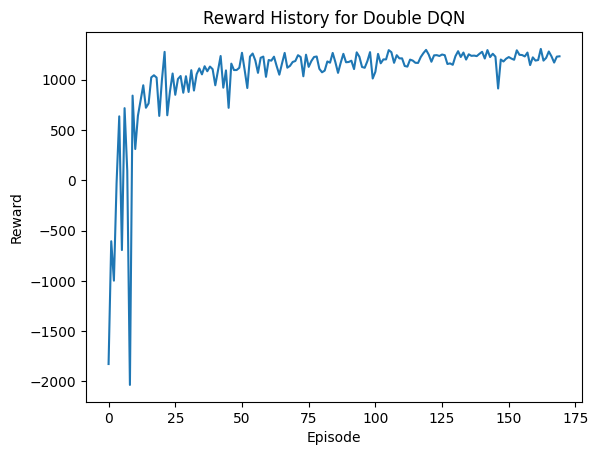

In [17]:
# plot the reward history
import matplotlib.pyplot as plt
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for Double DQN')
plt.show()


In [18]:
#save model
agent.policy_model.save('./models/DDQN_RCmaze.h5')


/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))


from keras.models import load_model
test_agent.policy_model = load_model('./models/DDQN_RCmaze.h5')


done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
   
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()

2024-01-15 09:48:42.285398: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_21/kernel/Assign' id:1492 op device:{requested: '', assigned: ''} def:{{{node dense_21/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_21/kernel, dense_21/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-15 09:48:42.374414: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_6_1/kernel/Assign' id:1839 op device:{requested: '', assigned: ''} def:{{{node dense_6_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_6_1/kernel, dense_6_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation 

done in  34 steps
1296.992428778307
